In [74]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("D:/estela/src/cilia_quantification.csv")
df

,label,area,axis_major_length,axis_minor_length,intensity_max,solidity,intensity_median,classes
0,1,719.0,18.294934,8.525367,174.0,0.896509,12.0,NaN
1,2,834.0,21.121715,8.043381,126.0,0.875131,12.0,NaN
2,3,749.0,17.807669,8.183166,133.0,0.858945,11.0,NaN
3,4,584.0,22.366502,6.900171,125.0,0.732748,12.0,NaN
4,5,457.0,20.177920,4.147177,67.0,0.887379,11.0,NaN
...,...,...,...,...,...,...,...,...
415,416,941.0,21.670160,8.111516,110.0,0.888574,14.0,NaN
416,417,500.0,14.569206,7.973495,153.0,0.904159,13.0,NaN
417,418,728.0,19.896112,7.929379,200.0,0.864608,13.0,NaN
418,419,937.0,21.872716,8.837211,180.0,0.893232,16.0,NaN


In [3]:
df_classes = df.dropna(subset=["classes"])
df_classes

,label,area,axis_major_length,axis_minor_length,intensity_max,solidity,intensity_median,classes
34,35,41335.0,430.224657,25.189398,122.0,0.053354,12.0,elongated
48,49,4207.0,30.180982,15.334478,222.0,0.811692,14.0,elongated
52,53,5945.0,68.243484,17.205946,182.0,0.409605,13.0,elongated
65,66,11353.0,155.541823,13.526839,127.0,0.369504,13.0,elongated
101,102,1106.0,20.890026,8.539950,133.0,0.863388,12.5,fibroblastic
102,103,991.0,16.593428,10.594777,255.0,0.868536,13.0,fibroblastic
103,104,718.0,15.640825,9.339870,251.0,0.886420,12.0,fibroblastic
108,109,473.0,13.805958,7.556105,110.0,0.885768,11.0,fibroblastic
109,110,775.0,18.296414,8.143986,139.0,0.874718,13.0,fibroblastic
110,111,681.0,15.209903,8.561274,171.0,0.889034,13.0,fibroblastic


In [83]:
X = df_classes[["solidity", "axis_minor_length"]]
y = df_classes["classes"]

scaler = StandardScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)

In [84]:
neigh = {}

In [85]:
neigh["uniform"] = KNeighborsClassifier(n_neighbors=5)
neigh["uniform"].fit(X_transformed, y)

KNeighborsClassifier()

In [101]:
neigh["distance"] = RadiusNeighborsClassifier(radius=4.0)
neigh["distance"].fit(X_transformed, y)

RadiusNeighborsClassifier(radius=4.0)

In [87]:
def get_color(kind):
    if kind == "elongated":
        return "blue"
    elif kind == "fibroblastic":
        return "red"
    elif kind == "looped":
        return "green"
    else:
        return "black"

In [88]:
y.apply(get_color)

34      blue
48      blue
52      blue
65      blue
101      red
102      red
103      red
108      red
109      red
110      red
115      red
116      red
122      red
123      red
124      red
126      red
129    green
138    green
142    green
166    green
173    green
178    green
193     blue
197      red
198      red
200      red
204      red
206      red
207    green
208    green
209      red
210      red
213      red
215      red
217      red
219    green
223      red
224      red
227    green
228    green
233      red
235      red
281     blue
Name: classes, dtype: object

c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


ValueError: No neighbors found for test samples array([9398, 9399, 9495, 9496, 9497, 9498, 9499, 9591, 9592, 9593, 9594,
       9595, 9596, 9597, 9598, 9599, 9686, 9687, 9688, 9689, 9690, 9691,
       9692, 9693, 9694, 9695, 9696, 9697, 9698, 9699, 9775, 9776, 9777,
       9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788,
       9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799,
       9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885,
       9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896,
       9897, 9898, 9899, 9974, 9975, 9976, 9977, 9978, 9979, 9980, 9981,
       9982, 9983, 9984, 9985, 9986, 9987, 9988, 9989, 9990, 9991, 9992,
       9993, 9994, 9995, 9996, 9997, 9998, 9999], dtype=int64), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.

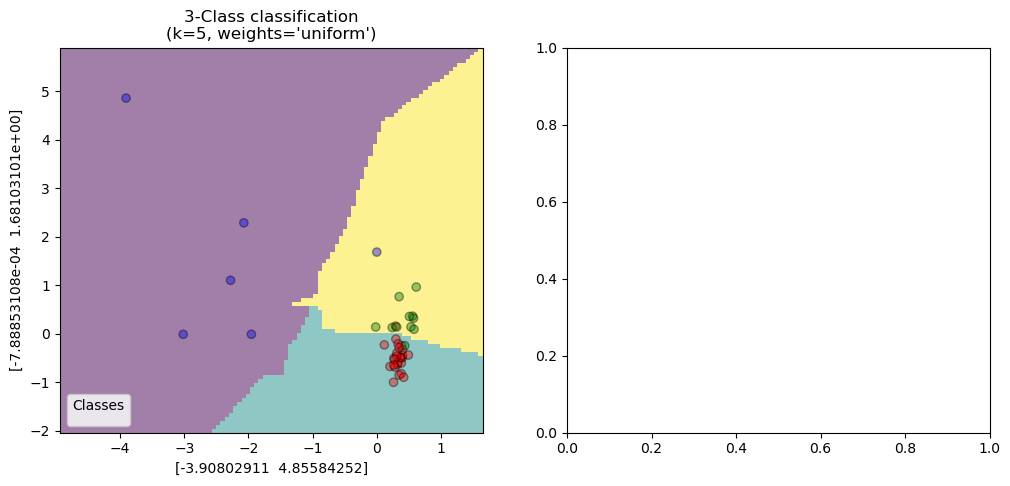

In [102]:
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    disp = DecisionBoundaryDisplay.from_estimator(
        neigh[weights],
        X_transformed,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=X_transformed.columns[0],
        ylabel=X_transformed.columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_transformed[:, 0],
        X_transformed[:, 1],
        c=y.apply(get_color),
        edgecolors="k",
        alpha=0.4,
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        y,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={neigh[weights].n_neighbors}, weights={weights!r})"
    )

plt.show()